In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Sample data loading (replace with your actual file path)


xls = pd.ExcelFile("falls1.xls")
dfs = []
for sheet_name in xls.sheet_names:
    df_sheet = xls.parse(sheet_name)
    df_sheet.columns = [str(col).strip().replace('\xa0', '').lower() for col in df_sheet.columns]
    
    # Add sheet name as a source tag (optional)
    df_sheet['source_sheet'] = sheet_name
    
    dfs.append(df_sheet)

# Step 2: Combine all into a single DataFrame
df_full = pd.concat(dfs, ignore_index=True)

# Step 3: Handle time column (normalize to seconds)
time_col = next((col for col in df_full.columns if 'time' in col), None)
df_full[time_col] = pd.to_numeric(df_full[time_col], errors='coerce')
df_full['time(s)'] = df_full[time_col] / 1000.0  # Assuming milliseconds

# Step 4: Show summary
print("Combined shape:", df_full.shape)
print("Columns:", df_full.columns.tolist())


Combined shape: (1491, 11)
Columns: ['source_sheet', 'pitch', 'roll', 'yaw', 'gyroy', 'gyrox', 'gyroz', 'time(ms)', 'count', 'time (ms)', 'time(s)']


In [6]:
features = ['gyrox', 'gyroy', 'gyroz', 'pitch', 'roll', 'yaw']
imu_data = df_full[features].to_numpy()

# Step 4: Sliding window segmentation
def sliding_window(data, window_size=30, step_size=10):
    return np.array([
        data[i:i + window_size]
        for i in range(0, len(data) - window_size + 1, step_size)
    ])

windowed_data = sliding_window(imu_data, window_size=30, step_size=10)

# Step 5: Flatten each window (30 × 6 → 180)
X = windowed_data.reshape(windowed_data.shape[0], -1)

# Step 6: Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train One-Class SVM
clf = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
clf.fit(X_scaled)

# Step 8: Predict anomalies
y_pred = clf.predict(X_scaled)  # +1 = normal, -1 = anomaly

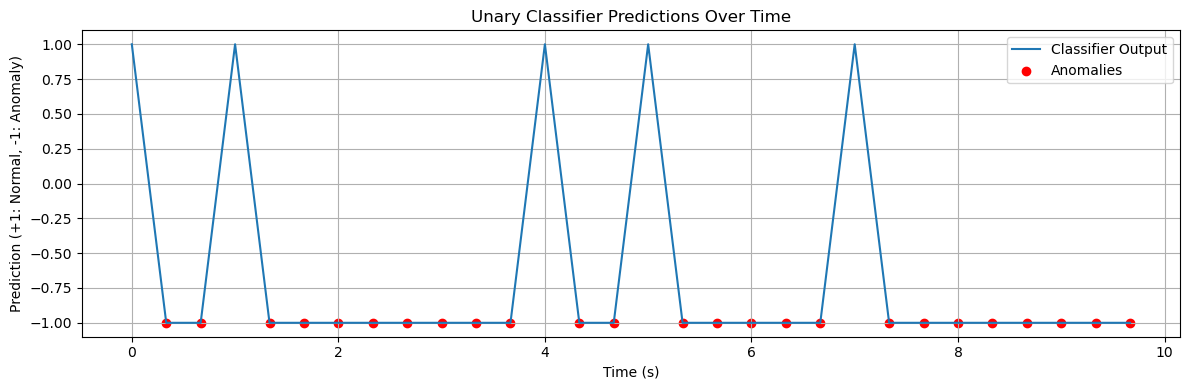

In [9]:
num_windows = 30
sampling_rate = 30     # Hz (samples per second)

# Time axis: one value per window, in seconds
time_axis = np.arange(num_windows) * step_size / sampling_rate

# Simulated classifier output (1 = normal, -1 = anomaly)
np.random.seed(0)
y_pred = np.ones(num_windows)
y_pred[np.random.choice(num_windows, 25, replace=False)] = -1  # Insert random anomalies
    
# Plotting
plt.figure(figsize=(12, 4))
plt.plot(time_axis, y_pred, label='Classifier Output')
plt.scatter(time_axis[y_pred == -1], y_pred[y_pred == -1], color='red', label='Anomalies')
plt.title("Unary Classifier Predictions Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Prediction (+1: Normal, -1: Anomaly)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()